In [ ]:
import os
import torch
from prepare_datasets import prepare_datasets
from build_dataloader import set_seed
from perform_grid_search import perform_grid_search
from train_test import train, validate
from model import GAT
from model_GCN import GCN
from explainer import explain_model
from build_dataloader import GraphDataset, collate_fn
from dgl.dataloading import GraphDataLoader
from sklearn.metrics import accuracy_score, f1_score
from performance_visualizations import plot_hyperparameter_boxplots
import pandas as pd

In [3]:
# Set random seed for reproducibility
set_seed(42)
base_dir = os.path.dirname(os.getcwd())

In [4]:

# Prepare datasets
datasets, feature_names_sc, feature_names_combined = prepare_datasets(base_dir, test_size = 0.15, random_state = 42)

In [5]:
dataset_name = 'sc'
train_graphs = datasets[f'train_graphs_{dataset_name}']
train_labels = datasets[f'train_labels_{dataset_name}']
test_graphs = datasets[f'test_graphs_{dataset_name}']
test_labels = datasets[f'test_labels_{dataset_name}']

In [5]:
param_grid_1 = { 
    'num_heads': [1,2,3],
    'out_channels': [8],
    'learning_rate': [0.01, 0.001],
    'weight_decay': [0]
}

Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 1, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping triggered at epoch 52 in fold 1
Starting fold 2/5
Early stopping triggered at epoch 21 in fold 2
Starting fold 3/5
Early stopping triggered at epoch 88 in fold 3
Starting fold 4/5
Early stopping triggered at epoch 22 in fold 4
Starting fold 5/5
Early stopping triggered at epoch 17 in fold 5
Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 2, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping triggered at epoch 27 in fold 1
Starting fold 2/5
Early stopping triggered at epoch 29 in fold 2
Starting fold 3/5
Early stopping triggered at epoch 104 in fold 3
Starting fold 4/5
Early stopping triggered at epoch 32 in fold 4
Starting fold 5/5
Early stopping triggered at epoch 17 in fold 5
Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 3, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stoppin

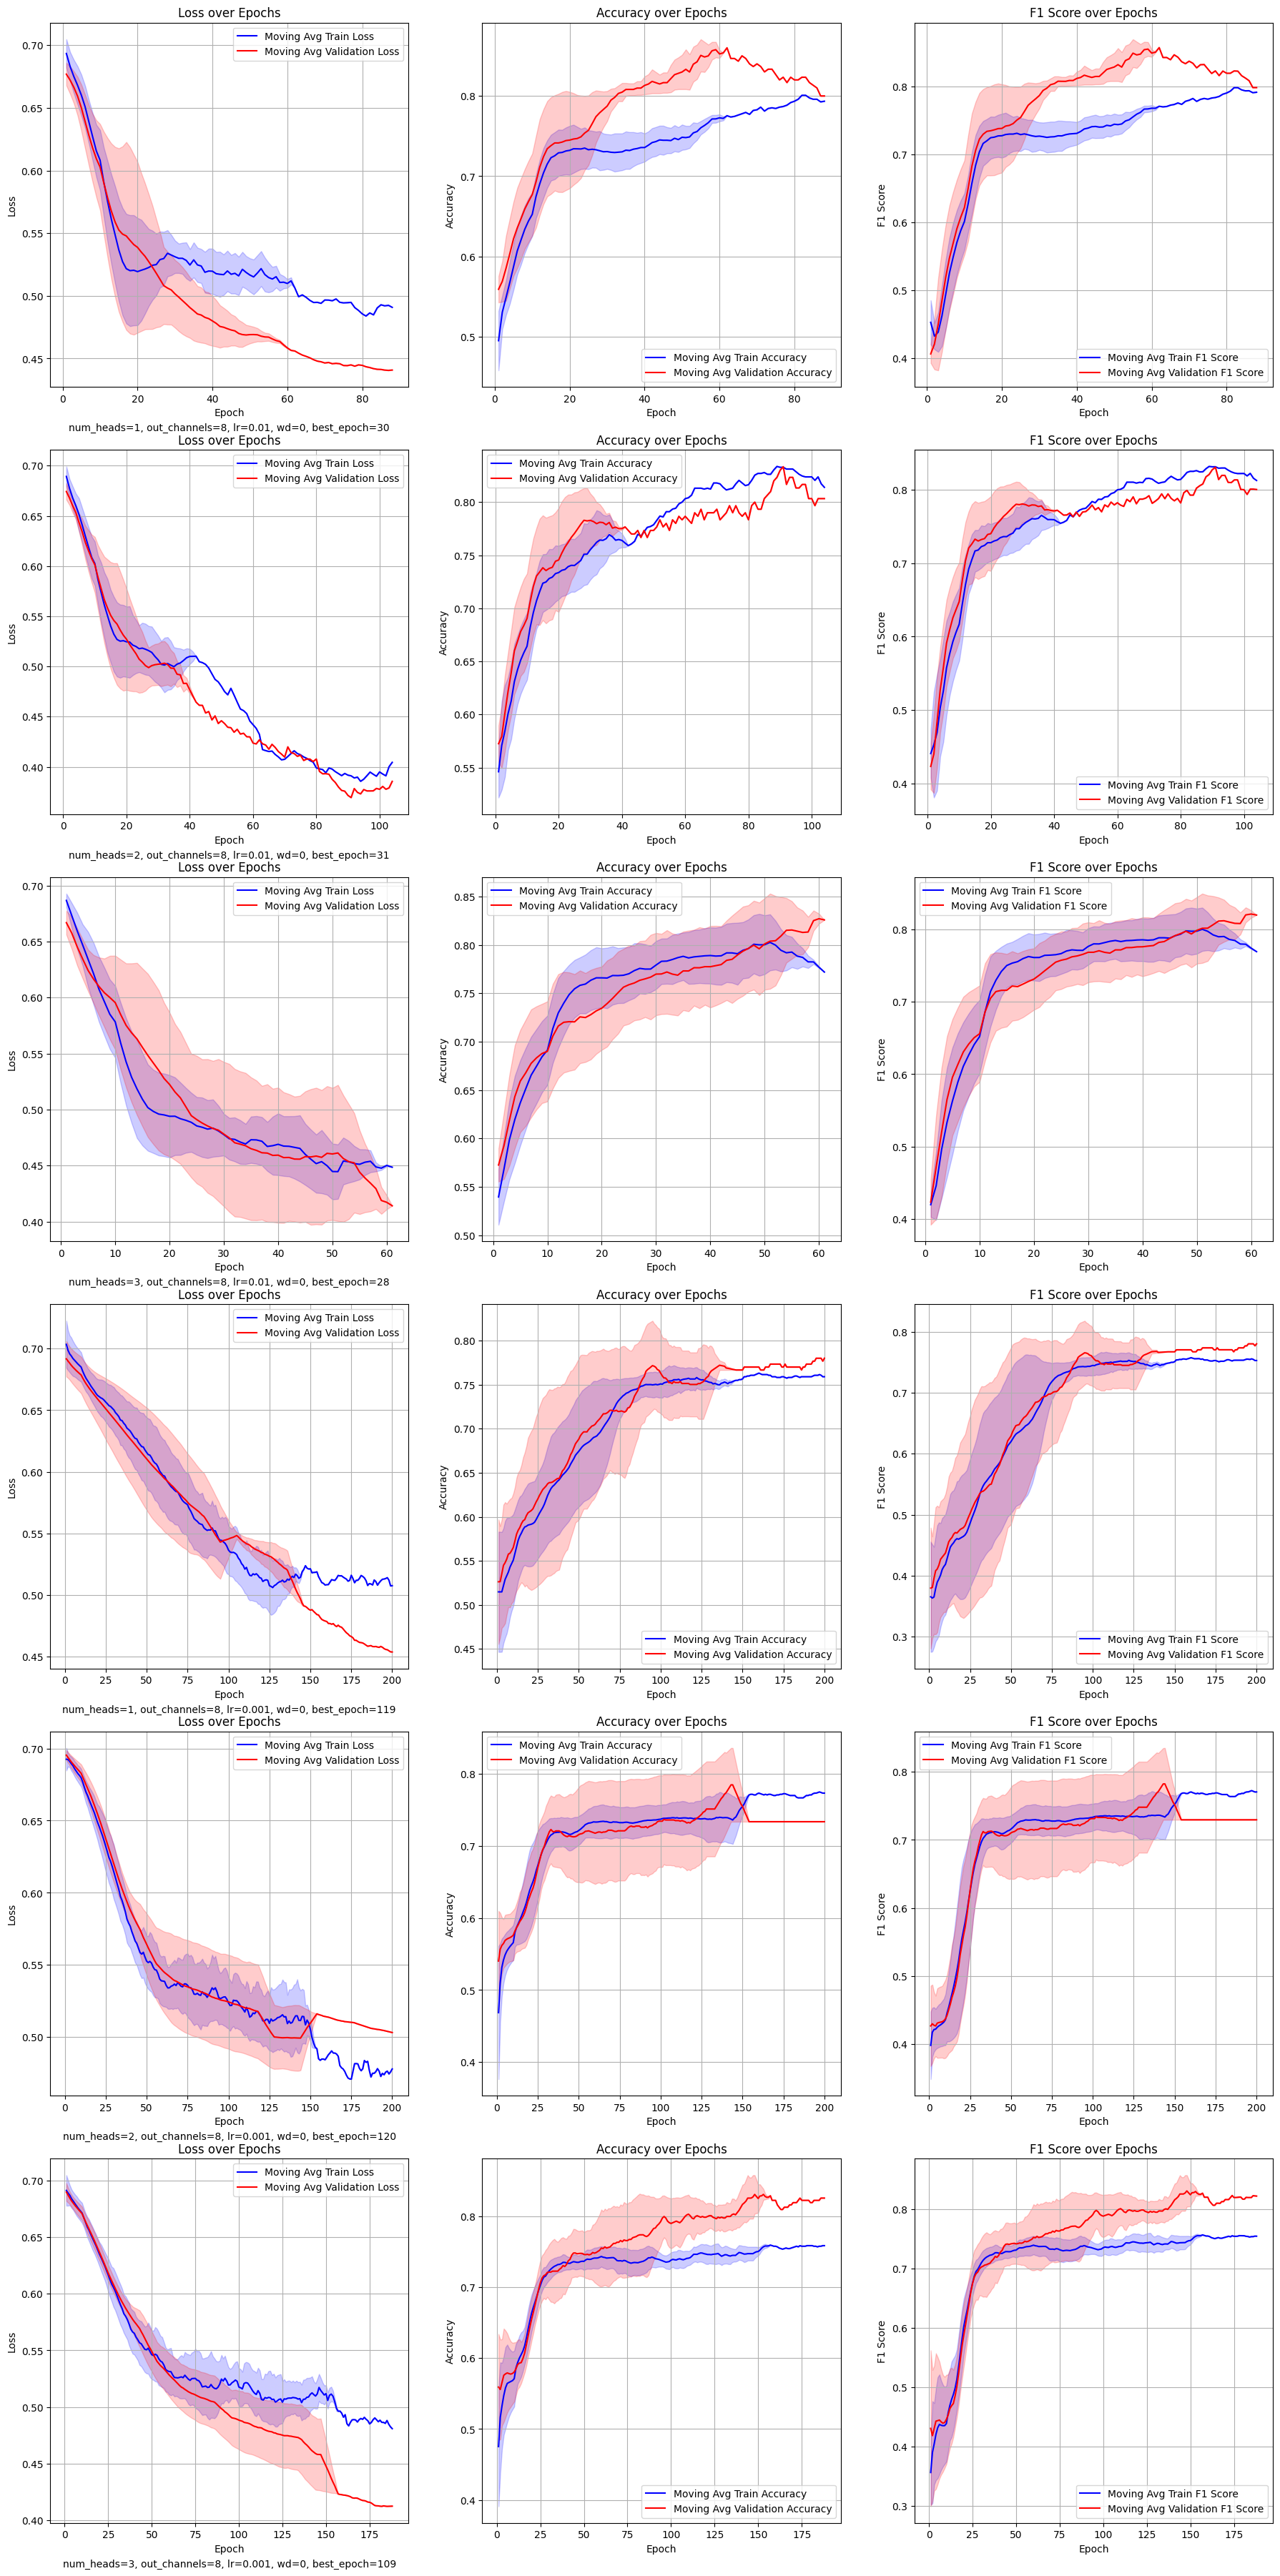

In [ ]:
from perform_cv_early_stopping import perform_cv_early_stopping
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params_1, best_val_f1_1, best_val_accuracy_1, best_epochs_trained_1, results_df_1 = perform_cv_early_stopping(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid_1,
    model_class=GAT,
    batch_size=8,
    device=device,
    patience = 10,
    max_epochs = 200
)


In [7]:
print("Best Hyperparameters (based on average validation F1):")
print(best_params_1)
print(f"Best Average Validation F1 Score: {best_val_f1_1}")
print(f"Best Average Validation Accuracy: {best_val_accuracy_1}")

Best Hyperparameters (based on average validation F1):
{'num_heads': 3.0, 'out_channels': 8.0, 'learning_rate': 0.001, 'weight_decay': 0.0}
Best Average Validation F1 Score: 0.7659535030113129
Best Average Validation Accuracy: 0.769247311827957


In [ ]:
# Save results_df to a CSV file for later analysis
#results_df_1.to_csv('first_grid_search_sc.csv', index=False)

In [12]:
best_params = {
    'num_heads': 3,
    'out_channels': 8,
    'learning_rate': 0.001,
    'weight_decay': 0
}

Epoch 1/109: Loss: 0.6947, F1: 0.2629
Epoch 2/109: Loss: 0.6830, F1: 0.5730
Epoch 3/109: Loss: 0.6714, F1: 0.6894
Epoch 4/109: Loss: 0.6624, F1: 0.6170
Epoch 5/109: Loss: 0.6555, F1: 0.5864
Epoch 6/109: Loss: 0.6503, F1: 0.5642
Epoch 7/109: Loss: 0.6460, F1: 0.5642
Epoch 8/109: Loss: 0.6398, F1: 0.6130
Epoch 9/109: Loss: 0.6345, F1: 0.6490
Epoch 10/109: Loss: 0.6289, F1: 0.6927
Epoch 11/109: Loss: 0.6224, F1: 0.7036
Epoch 12/109: Loss: 0.6165, F1: 0.6977
Epoch 13/109: Loss: 0.6104, F1: 0.7139
Epoch 14/109: Loss: 0.6045, F1: 0.7177
Epoch 15/109: Loss: 0.5982, F1: 0.7150
Epoch 16/109: Loss: 0.5922, F1: 0.7150
Epoch 17/109: Loss: 0.5880, F1: 0.7134
Epoch 18/109: Loss: 0.5837, F1: 0.7210
Epoch 19/109: Loss: 0.5778, F1: 0.7150
Epoch 20/109: Loss: 0.5741, F1: 0.7271
Epoch 21/109: Loss: 0.5709, F1: 0.7194
Epoch 22/109: Loss: 0.5690, F1: 0.7164
Epoch 23/109: Loss: 0.5676, F1: 0.7134
Epoch 24/109: Loss: 0.5614, F1: 0.7210
Epoch 25/109: Loss: 0.5602, F1: 0.7373
Epoch 26/109: Loss: 0.5569, F1: 0.

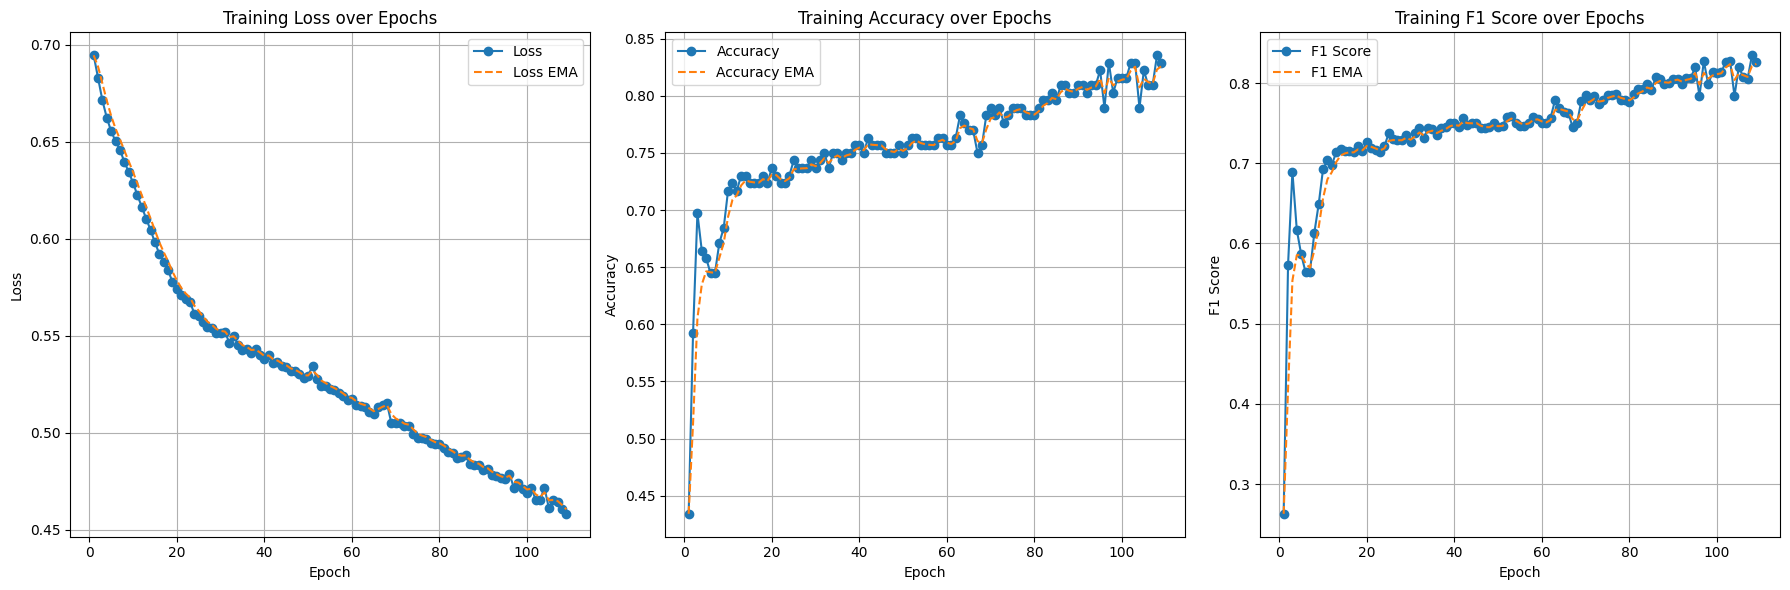

In [13]:
# train on all data

from train_all_data import train_model_on_all_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model_on_all_data( 
    train_graphs, 
    train_labels, 
    dataset_name='sc',
    best_params = best_params, 
    max_epochs = 109, 
    batch_size=8, 
    device = device)

In [ ]:
from prepare_datasets import compute_feature_means_stds, compute_edge_attr_means_stds, normalize_graph_features, normalize_graph_edge_weights

train_mean_x, train_std_x = compute_feature_means_stds(train_graphs)
train_mean_edge_attr, train_std_edge_attr = compute_edge_attr_means_stds(train_graphs)

In [ ]:
best_model_path = os.path.join(base_dir, 'src1', 'best_model_sc.pth')


from test_best_model import test_model

test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels,
    model_class=GAT,
    train_mean_x=train_mean_x,
    train_std_x=train_std_x,
    train_mean_edge_attr=train_mean_edge_attr,
    train_std_edge_attr=train_std_edge_attr,
    batch_size=8
)

Test Loss: 0.4936, Test Accuracy: 0.7778, Test F1: 0.7784


In [ ]:
# Benchmarking with GCN

from model_GCN import GCN

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params_1, best_val_f1_1, best_val_accuracy_1, best_epochs_trained_1, results_df_1 = perform_cv_early_stopping(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid_1,
    model_class=GCN,
    batch_size=8,
    device=device,
    patience = 10,
    max_epochs = 200
)

In [ ]:
# Set the best hyperparameters
best_params_2 = {
    'num_heads': 3,
    'out_channels': 8,
    'learning_rate': 0.01,
    'weight_decay': 0
}

In [ ]:
# Train the best model on all data
# train on all data

from train_all_data import train_model_on_all_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model_on_all_data( 
    train_graphs, 
    train_labels, 
    dataset_name='sc_gcn',
    best_params = best_params_2, 
    model_class=GCN,
    max_epochs = 24, 
    batch_size=8, 
    device = device)

In [ ]:
best_model_path = os.path.join(base_dir, 'src1', 'best_model_sc_gcn.pth')


from test_best_model import test_model
test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels,
    model_class=GCN,
    train_mean_x=train_mean_x,
    train_std_x=train_std_x,
    train_mean_edge_attr=train_mean_edge_attr,
    train_std_edge_attr=train_std_edge_attr,
    batch_size=8
)